In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import sys
sys.path.insert(1, '../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
sys.path.insert(1, '../../../python-scripts-c6fxKDJrSsWp1xCxON1Y7g')
from api_calls import *

url = "https://nomad-hzb-ce.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN']

### EDAQ Analysis

**Insert the name of your data file here.** You can also adapt the other parameters.

In [2]:
run_number = 1
gse_file_name = f'exampledata_GSE_CP{run_number}.txt'

# this is the size of a sliding window to calculate a moving average (-> smooth data because we have a lot of double values)
# at the moment set to 60s but can be changed
window_size = 60

# since some curves are also flat in the beginning you can set this number
# derivatives are only checked after this starting time (in s)
starting_time = 0

# this is the threshold of the derivative
# as soon as the derivative gets smaller than this threshold the time is used as the result
threshold = 0.0001

# GSE calibration curve parameters (recorded 25.04.2025)
slope = -55.58
intercept = 31.72

Now we can do all calculations.

In [3]:
data = pd.read_csv(gse_file_name, skiprows=4, sep=' ', header=None, names=['Time [s]', 'Potential [mV]', 'CP Potential [mV]'])
data['Time [s]'] = pd.to_timedelta(data['Time [s]']).dt.total_seconds()

data['Smoothed_Voltage'] = data['Potential [mV]'].rolling(window=window_size).mean()
# calculate derivatives
data['Voltage_Diff'] = np.gradient(data['Potential [mV]'], data['Time [s]'])
data['Smoothed_Voltage_Diff'] = np.gradient(data['Smoothed_Voltage'], data['Time [s]'])
# find time < threshold
threshold_data = data[starting_time:]
flatten_point_tmp =  threshold_data.loc[abs(threshold_data['Smoothed_Voltage_Diff']) < threshold]
if len(flatten_point_tmp) > 0:
    flatten_point = flatten_point_tmp.iloc[0]
else:
    print("Gradient did not vanish, choosing last point")
    flatten_point = threshold_data.iloc[-1]

# uncomment the next row to see all rows
# pd.set_option('display.max_rows', None)
data

,Time [s],Potential [mV],CP Potential [mV],Smoothed_Voltage,Voltage_Diff,Smoothed_Voltage_Diff
0,1.0,54.14,184.68,NaN,0.000,NaN
1,2.0,54.14,184.68,NaN,-0.010,NaN
2,3.0,54.12,417.00,NaN,-0.010,NaN
3,4.0,54.12,417.00,NaN,0.065,NaN
4,5.0,54.25,622.59,NaN,0.065,NaN
...,...,...,...,...,...,...
610,611.0,45.96,385.66,45.9705,-0.005,-0.0005
611,612.0,45.96,385.66,45.9700,-0.005,-0.0005
612,613.0,45.95,504.38,45.9695,-0.005,-0.0005
613,614.0,45.95,504.38,45.9690,-0.055,-0.0015


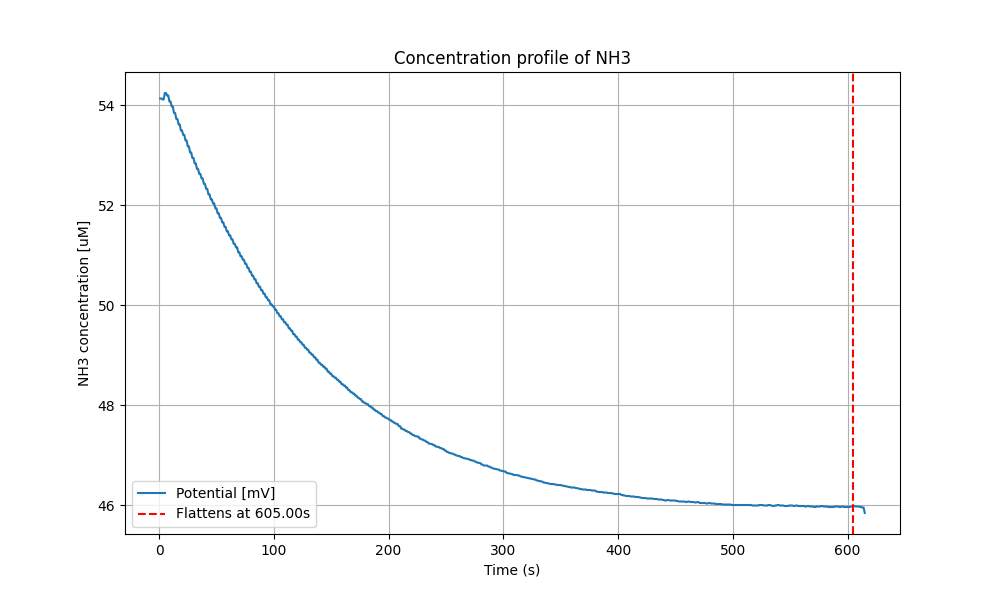

In [4]:
# make plot
plt.figure(figsize=(10, 6))
plt.plot(data['Time [s]'], data['Potential [mV]'], label='Potential [mV]', marker=None)

plt.axvline(flatten_point['Time [s]'], color='red', linestyle='--', label=f'Flattens at {flatten_point["Time [s]"]:.2f}s')

# label axis
plt.xlabel('Time (s)')
plt.ylabel('NH3 concentration [uM]')

plt.title('Concentration profile of NH3')
plt.legend()

# show plot
plt.grid(True)
plt.show()